# Import Packages and Reading of Data

In [1]:
import time
import warnings
import pickle
import shap

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb # recommended version: 1.5.0

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import plot_importance
from bayes_opt import BayesianOptimization

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
# Reading of Excel
dataset = pd.read_csv('cleaned_others_dataset.csv')

In [3]:
dataset

,protected,verified,location,followers_count,following_count,tweet_count,isFraud,un_no_of_char,un_special_char,un_uppercase,name_no_of_char,name_special_char,name_uppercase,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,account_age_in_days
0,0,0,0,1997,5,17090,1,15,1,0,19,0,1,2,0,0,1,2184
1,0,0,1,785,829,251,0,12,0,1,8,0,1,0,0,0,1,2159
2,0,0,0,243,1232,1469,0,8,0,1,11,0,0,0,0,0,1,1939
3,0,0,1,749,838,2518,0,11,0,1,15,0,1,0,0,0,1,2270
4,0,1,1,737048,128,4739,0,13,0,1,14,0,1,1,0,0,1,3919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35693,0,1,1,367523,17291,24084,0,14,0,1,10,0,1,2,0,0,1,4704
35694,0,0,1,14,0,238,0,8,1,1,8,0,1,0,0,0,1,4289
35695,0,0,0,395,492,21437,1,14,0,1,16,0,1,0,0,0,1,3792
35696,0,0,0,159,618,3021,0,8,0,1,14,0,1,0,0,0,0,2659


# Feature Engineering
* Scale numerical features
* One Hot Encode for categorical/ordinal features

In [4]:
# Getting X and y
x = dataset.drop(columns = ['isFraud'])
y = dataset['isFraud']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=101)
print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (28558, 17) (28558,)
Test set: (7140, 17) (7140,)


In [5]:
# # We only want to scale the numeric variables and not the categorical features. 
# # Hence, we create a columntransformer to help us to do this
# scaler = StandardScaler()

# x_train[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char', 'name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']] = scaler.fit_transform(x_train[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']])

# x_test[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char', 'name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']] = scaler.transform(x_test[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']])

# # Transform the year column into a categorical variable and store the result in a dataframe
# encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
# transformed_year_train_matrix = encoder.fit_transform(x_train[['year']])
# transformed_year_train = pd.DataFrame(transformed_year_train_matrix, columns = encoder.get_feature_names())

# # Using the fitted encoder to transform the test data and storing in a dataframe
# transformed_year_test_matrix = encoder.transform(x_test[['year']])
# transformed_year_test = pd.DataFrame(transformed_year_test_matrix, columns = encoder.get_feature_names())

# # Reset the index for training and testing sets to allow merging with the one hot encoded variables
# # Drop the index column 
# x_train.reset_index(inplace = True, drop = True)
# x_test.reset_index(inplace = True, drop = True)
# y_train.reset_index(drop = True, inplace = True)
# y_test.reset_index(drop = True, inplace = True)

# # Combine the scaled numeric variables together with the year categorical variables
# x_train = pd.concat([x_train, transformed_year_train], axis = 1)
# x_test = pd.concat([x_test, transformed_year_test], axis = 1)

# # Drop the year column since we already have the dummy variables for year
# x_train.drop(labels = ['year'], axis = 1, inplace = True)
# x_test.drop(labels = ['year'], axis = 1, inplace = True)

In [6]:
# A class that combines all the preprocessing steps (for model pipeline purpose)
class ExperimentalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, numeric_variables = ['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags', 'account_age_in_days']):
        self.encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
        self.scaler = StandardScaler()
        #specified numeric variables, by default it is the above
        self.numeric_variables = numeric_variables
        self.columns = []
    
    #The fit function that will be called when this custom transformer is fit
    def fit(self, X, y = None):
        #fit the one hot encoder to the year
#         self.encoder.fit(X[['year']])
        #fit the scaler on the numeric variables
        self.scaler.fit(X[self.numeric_variables])
        return self
    
    #The transform function that will be called
    def transform(self, X, y = None):
        
        #to avoid changing the original dataset
        X_ = X.copy()
        #transforming the numeric variables according to the fitted scaler
        X_[self.numeric_variables] = self.scaler.transform(X_[self.numeric_variables])
        
#         #next, create a date matrix using the fitted encoder
#         transformed_year_matrix = self.encoder.transform(X_[['year']])
#         #get the dataframe
#         year_cols = list(map(lambda year: year.replace('x0', 'year'), self.encoder.get_feature_names()))
#         transformed_year_train = pd.DataFrame(transformed_year_matrix, columns = year_cols)
#         #reset the index of the original dataframe
#         X_.reset_index(drop = True, inplace = True)
#         X_ = pd.concat([X_, transformed_year_train], axis = 1)
#         #drop the year column from the dataframe
#         X_.drop(labels = ['year'], inplace = True, axis = 1)
        self.columns = X_.columns
        return X_

# Charts and Functions

In [7]:
# def feature_chart(shap_values, x_test_values, names, model_type):
# #     feature_importance_df = pd.DataFrame(model.coef_.T, x_train.columns.T,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
# #     fig = feature_importance_df.plot(kind="barh", figsize=(20, 50))
# #     bg = fig.patch
# #     plt.gca().invert_yaxis()
#     shap.summary_plot(shap_values, x_test_values, feature_names = names, plot_type = "bar", sort = True)
#     plt.grid()
# #     plt.savefig(f'Charts\\{model_type} Feature Importance.png', dpi=300)
#     plt.show()

# model = SVC()
# model.fit(x_train, y_train)
# explainer = shap.Explainer(model.predict, x_test, feature_perturbation="interventional")
# shap_values = explainer(x_test)
# x_test_arr = x_test.toarray()
# feature_chart(shap_values, x_test_arr, x_test.columns, model_type)
    
def feature_chart(feature_importance_df, model_type):
#     feature_importance_df = pd.DataFrame(model.coef_.T, x_train.columns.T,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
    fig = feature_importance_df.plot(kind="barh", figsize=(12, 15))
    bg = fig.patch
    bg.set_facecolor("white")
    plt.gca().invert_yaxis()
    plt.grid()
#     plt.savefig(f'Charts\\{model_type} Feature Importance.png', dpi=300, facecolor=fig.get_facecolor())
    plt.show()

# Models

## 00 Baseline
* Model 
* Error Metrics

In [8]:
# Model
baseline = DummyClassifier(strategy = "uniform", 
                           random_state = 123)
transformer = ExperimentalTransformer()
baseline_pipeline = make_pipeline(transformer, baseline)
baseline_model = baseline_pipeline.fit(x_train, y_train)

In [9]:
# y_prediction
y_pred = baseline_model.predict(x_test)

In [10]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred)
print(f'Classification Report: \n {report}')

Accuracy: 0.4984593837535014
Log Loss: 17.32286561799182
ROC AUC: 0.49709709630920706
F1-score: 0.3949991552627133
Precision: 0.3294813979706877
Recall: 0.4930409110080135
Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.50      0.57      4769
           1       0.33      0.49      0.39      2371

    accuracy                           0.50      7140
   macro avg       0.50      0.50      0.48      7140
weighted avg       0.55      0.50      0.51      7140



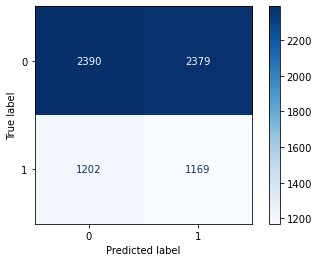

In [11]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(baseline_model, x_test, y_test, cmap = "Blues")
plt.show()

## 01 Logistic Regression
* Model 
* Error Metrics
* Plot for Feature Importance

In [12]:
# Model
log_regression = LogisticRegression()
transformer = ExperimentalTransformer()
log_model_pipeline = make_pipeline(transformer, log_regression)
log_model = log_model_pipeline.fit(x_train, y_train)

In [13]:
# Save the model to disk
# filename = '01 Logistic Regression.sav'
# pickle.dump(log_model, open(filename, 'wb'))

# Load the model from disk
# results_random = pickle.load(open(filename, 'rb'))

In [14]:
# R-Squared
log_model.score(x_train, y_train)

0.7387422088381539

In [15]:
# y_prediction
y_pred = log_model.predict(x_test)

In [16]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred)
print(f'Classification Report: \n {report}')

Accuracy: 0.7365546218487395
Log Loss: 9.099155032595009
ROC AUC: 0.6734228483743111
F1-score: 0.5503227348792733
Precision: 0.6352097130242825
Recall: 0.48544917756221
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.86      0.81      4769
           1       0.64      0.49      0.55      2371

    accuracy                           0.74      7140
   macro avg       0.70      0.67      0.68      7140
weighted avg       0.73      0.74      0.73      7140



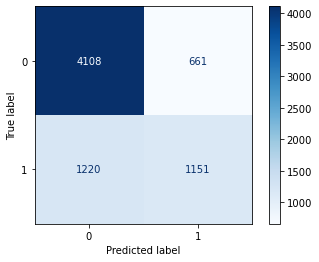

In [17]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(log_model, x_test, y_test, cmap = "Blues")
plt.show()

### Feature Importance

In [18]:
# Feature importance
feature = pd.DataFrame(log_model.named_steps["logisticregression"].coef_.T, log_model.named_steps["experimentaltransformer"].columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

,Feature Importance
des_external_links,1.296929
tweet_count,0.187803
following_count,0.092131
followers_count,-0.003816
un_no_of_char,-0.004375
name_no_of_char,-0.026632
name_uppercase,-0.026993
un_uppercase,-0.121555
des_no_of_usertags,-0.158320
name_special_char,-0.168834


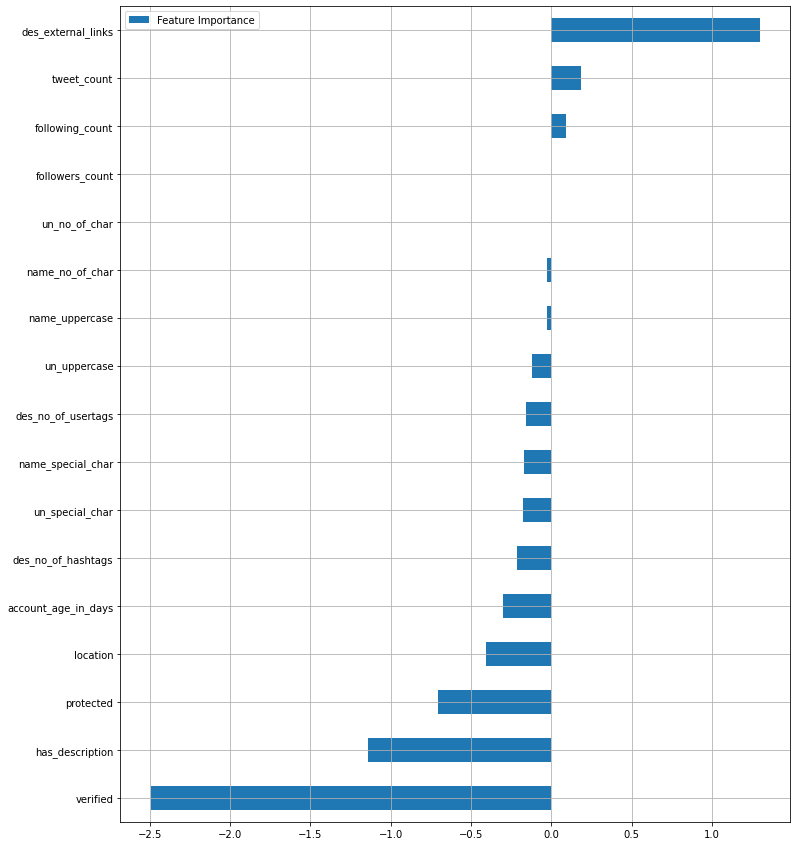

In [19]:
# Feature importance
feature_chart(feature, "Logistic Regression")

## 02 Random Forest
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

### Model (Random Search)

In [20]:
# Model
rf_classifier = RandomForestClassifier()
transformer = ExperimentalTransformer()
rf_model = make_pipeline(transformer, rf_classifier)

space = dict()

# Number of trees in random forest
space["randomforestclassifier__n_estimators"] = [10, 50, 200, 600, 800, 1200]

# Number of features to consider at every split (this parameter avoids overfitting by limiting how many features each leaf node can look at) 
space["randomforestclassifier__max_features"] = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree (how deep the tree goes)
space["randomforestclassifier__max_depth"] = [None, 10, 40, 80, 120]

# Minimum number of samples required to split a node
space["randomforestclassifier__min_samples_split"] = [2, 10, 40, 100]

# Method of selecting samples for training each tree (bootstrap sampling or not)
space["randomforestclassifier__bootstrap"] = [True, False]

# Define search
random_search = RandomizedSearchCV(rf_model, 
                                   space, 
                                   scoring = 'f1',
                                   cv = 5, 
                                   verbose = 2, 
                                   random_state = 123, 
                                   n_jobs = -1)

In [21]:
%%time

# Execute search
results_random_rf = random_search.fit(x_train, np.ravel(y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 29.4 s
Wall time: 3min 22s


In [22]:
# Save the model to disk
# filename = '02 Random Forest (random).sav'
# pickle.dump(results_random, open(filename, 'wb'))

# Load the model from disk
# results_random = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_random_rf.best_score_)
print('Best Hyperparameters: %s' % results_random_rf.best_params_)

Best Score: 0.7656786264282147
Best Hyperparameters: {'randomforestclassifier__n_estimators': 800, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 40, 'randomforestclassifier__bootstrap': True}


In [23]:
# y_prediction for the best model using RandomSearchCV
y_pred_random = results_random_rf.predict(x_test)

In [24]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_random)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_random)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random)
print(f'Recall: {recall}')

Accuracy: 0.8610644257703082
Log Loss: 4.798700007975058
ROC AUC: 0.8242074433514139
F1-score: 0.7735159817351597
Precision: 0.8432055749128919
Recall: 0.7144664698439477


### Model (Grid Search)

In [25]:
# Model
rf_classifier = RandomForestClassifier()
transformer = ExperimentalTransformer()
rf_model = make_pipeline(transformer, rf_classifier)

grid = dict()

# Number of trees in random forest
grid["randomforestclassifier__n_estimators"] = [10, 50, 200, 600, 800, 1200]

# Number of features to consider at every split
grid["randomforestclassifier__max_features"] = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree (how deep the tree goes)
grid["randomforestclassifier__max_depth"] = [None, 10, 40, 80, 120]

# Minimum number of samples required to split a node
grid["randomforestclassifier__min_samples_split"] = [2, 10, 40, 100]

# Method of selecting samples for training each tree (bootstrap sampling or not)
grid["randomforestclassifier__bootstrap"] = [True, False]

# Define search
grid_search = GridSearchCV(rf_model, 
                           grid, 
                           scoring = 'f1',
                           cv = 5, 
                           n_jobs = -1, 
                           verbose = 2)

In [26]:
%%time

# Execute search
results_grid_rf = grid_search.fit(x_train, np.ravel(y_train))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
CPU times: total: 1min 21s
Wall time: 4h 21min 36s


In [27]:
# Save the model to disk
# filename = '02 Random Forest (grid).sav'
# pickle.dump(results_grid, open(filename, 'wb'))

# Load the model from disk
# results_grid = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_grid_rf.best_score_)
print('Best Hyperparameters: %s' % results_grid_rf.best_params_)

Best Score: 0.7671844370370113
Best Hyperparameters: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 800}


In [28]:
# y_prediction for the best model using GridSearchCV
y_pred_grid = results_grid_rf.predict(x_test)

In [30]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')

Accuracy: 0.8603641456582634
Log Loss: 4.8228877220862625
ROC AUC: 0.8240013375431215
F1-score: 0.7729446595308586
Precision: 0.8400990099009901
Recall: 0.7157317587515816


### Model (Optimal Hyperparameters)

In [31]:
print("Grid Search:", results_grid_rf.best_score_) 
print("Randomised Search:", results_random_rf.best_score_) 

Grid Search: 0.7671844370370113
Randomised Search: 0.7656786264282147


In [32]:
# Model (initialise the object based on parameters selected by grid search)
params_rf = results_grid_rf.best_params_

rf_classifier = RandomForestClassifier(bootstrap = params_rf["randomforestclassifier__bootstrap"], 
                                       max_depth = params_rf["randomforestclassifier__max_depth"], 
                                       max_features = params_rf["randomforestclassifier__max_features"], 
                                       min_samples_split = params_rf["randomforestclassifier__min_samples_split"], 
                                       n_estimators = params_rf["randomforestclassifier__n_estimators"])

transformer = ExperimentalTransformer()
rf_model_pipeline = make_pipeline(transformer, rf_classifier)
rf_model = rf_model_pipeline.fit(x_train, np.ravel(y_train))

# Save the model to disk
# filename = '02 Random Forest (Optimal).sav'
# pickle.dump(rf_model, open(filename, 'wb'))

# Load the model from disk
# rf_regression = pickle.load(open(filename, 'rb'))

In [33]:
# y_prediction for the best model
y_pred_optimal = rf_model.predict(x_test)

In [34]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_optimal)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_optimal)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_optimal)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred_optimal)
print(f'Classification Report: \n {report}')

Accuracy: 0.8595238095238096
Log Loss: 4.851912239896031
ROC AUC: 0.8230541617410134
F1-score: 0.7715782281940333
Precision: 0.8386138613861386
Recall: 0.7144664698439477
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4769
           1       0.84      0.71      0.77      2371

    accuracy                           0.86      7140
   macro avg       0.85      0.82      0.84      7140
weighted avg       0.86      0.86      0.86      7140



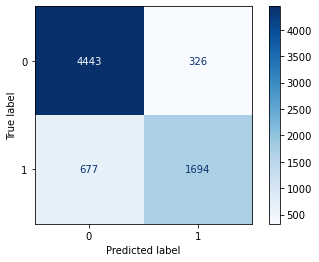

In [35]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model, x_test, y_test, cmap = "Blues")
plt.show()

### Feature Importance

In [36]:
# rf_model.feature_importances_
feature = pd.DataFrame(rf_model.named_steps["randomforestclassifier"].feature_importances_, rf_model.named_steps["experimentaltransformer"].columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

,Feature Importance
followers_count,0.279021
following_count,0.191611
tweet_count,0.174434
account_age_in_days,0.122207
name_no_of_char,0.046438
verified,0.040036
un_no_of_char,0.030587
has_description,0.028887
des_external_links,0.017696
location,0.016009


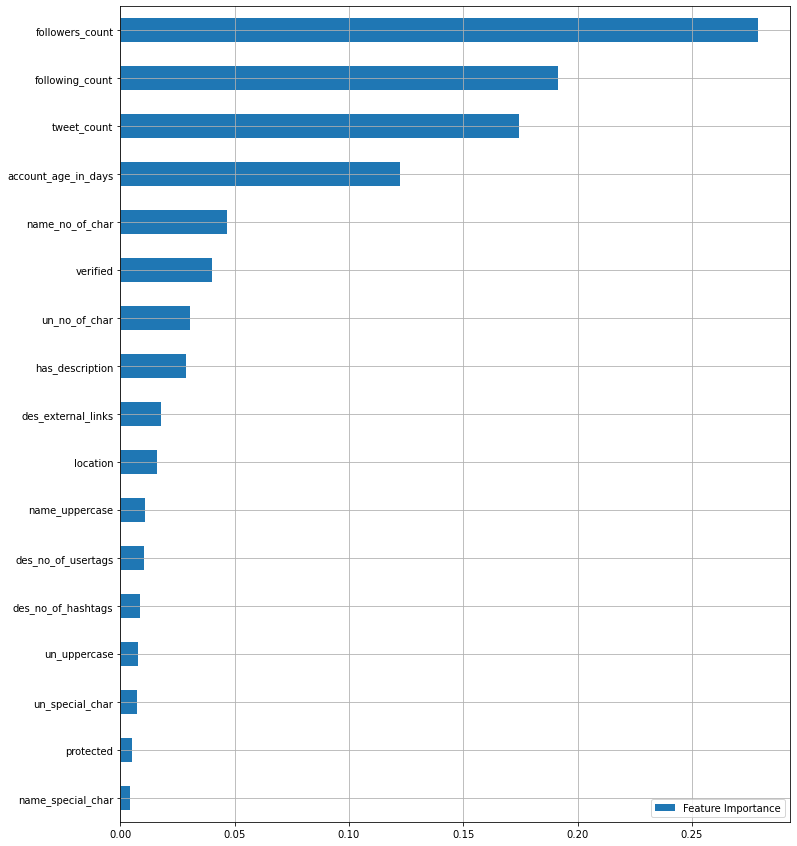

In [37]:
feature_chart(feature, "Random Forest")

## 03 XGBoost
* Model (Random Search + Grid Search + Bayesian Optimisation)
* Error Metrics
* Plot for Feature Importance

### Model (Random Search)

In [38]:
weight_train = y_train.value_counts()[0] / y_train.value_counts()[1]

In [39]:
xgb_classifier = xgb.XGBClassifier(gamma = 0.1,
                                   alpha = 0.5,
                                   scale_pos_weight = weight_train,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")
transformer = ExperimentalTransformer()
xgb_model = make_pipeline(transformer, xgb_classifier)

space = dict()

# Maximum depth of the individual regression estimators
space["xgbclassifier__max_depth"] = [6, 10, 15, 20, 25]

# Fraction of samples to be used for fitting the individual base learners
space["xgbclassifier__subsample"] = [0.6, 0.8, 1.0]

# Step size shrinkage used in update to prevents overfitting
space["xgbclassifier__eta"] = [0.01, 0.1, 0.2]

# Subsample ratio of columns when constructing each tree
space["xgbclassifier__colsample_bytree"] = [0.5, 0.6, 0.7, 0.8, 0.9]

# Define Search
random_search = RandomizedSearchCV(estimator = xgb_model,
                                   param_distributions = space,
                                   scoring = 'f1',
                                   n_jobs = -1,
                                   cv = 5,
                                   verbose = 10,
                                   n_iter = 50,
                                   random_state = 123)

In [40]:
%%time

# Execute Search
results_random_xgb = random_search.fit(x_train, y_train)
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# CPU times: user 1min 23s, sys: 3.7 s, total: 1min 27s
# Wall time: 1h 29min 45s

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 37.3 s
Wall time: 8min 18s


In [41]:
# filename = 'random_all.sav'
# pickle.dump(random_search, open(filename, 'wb'))

print('Best Score: %s' % results_random_xgb.best_score_)
print('Best Hyperparameters: %s' % results_random_xgb.best_params_)

# print(results_random.best_params_)
# print("Randomised Search:", results_random.best_score_)

Best Score: 0.7741915612584716
Best Hyperparameters: {'xgbclassifier__subsample': 0.6, 'xgbclassifier__max_depth': 20, 'xgbclassifier__eta': 0.01, 'xgbclassifier__colsample_bytree': 0.8}


In [42]:
# y_prediction for the best model using RandomSearchCV
y_pred_random = results_random_xgb.predict(x_test)

In [43]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_random)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_random)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random)
print(f'Recall: {recall}')

Accuracy: 0.8483193277310924
Log Loss: 5.238923168900477
ROC AUC: 0.8268609948317454
F1-score: 0.7696234843650287
Precision: 0.7763948497854077
Recall: 0.7629692113032476


### Model (Grid Search)

In [44]:
xgb_classifier = xgb.XGBClassifier(gamma = 0.1,
                                   alpha = 0.5,
                                   scale_pos_weight = weight_train,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")
transformer = ExperimentalTransformer()
xgb_model = make_pipeline(transformer, xgb_classifier)

grid = dict()

# Maximum depth of the individual regression estimators
grid["xgbclassifier__max_depth"] = [6, 10, 15, 20, 25]

# Fraction of samples to be used for fitting the individual base learners
grid["xgbclassifier__subsample"] = [0.6, 0.8, 1.0]

# Step size shrinkage used in update to prevents overfitting
grid["xgbclassifier__eta"] = [0.01, 0.1, 0.2]

# Subsample ratio of columns when constructing each tree
grid["xgbclassifier__colsample_bytree"] = [0.5, 0.6, 0.7, 0.8, 0.9]

grid_search = GridSearchCV(estimator = xgb_model,
                           param_grid = grid,
                           scoring = 'f1',
                           n_jobs = -1,
                           cv = 5,
                           verbose = True)

In [45]:
%%time

results_grid_xgb = grid_search.fit(x_train, y_train)
# Fitting 5 folds for each of 225 candidates, totalling 1125 fits
# CPU times: user 2min 51s, sys: 15.3 s, total: 3min 6s
# Wall time: 6h 58min 5s

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
CPU times: total: 21.5 s
Wall time: 32min 58s


In [46]:
print('Best Score: %s' % results_grid_xgb.best_score_)
print('Best Hyperparameters: %s' % results_grid_xgb.best_params_)

Best Score: 0.7756454329353406
Best Hyperparameters: {'xgbclassifier__colsample_bytree': 0.9, 'xgbclassifier__eta': 0.1, 'xgbclassifier__max_depth': 10, 'xgbclassifier__subsample': 0.8}


In [47]:
# y_prediction for the best model using GridSearchCV
y_pred_grid = results_grid_xgb.predict(x_test)

In [48]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')

Accuracy: 0.8487394957983193
Log Loss: 5.224413877689136
ROC AUC: 0.8301445818316115
F1-score: 0.7728228859907446
Precision: 0.7708770457406631
Recall: 0.774778574441164


### Model (Bayesian Optimisation)

In [49]:
def xgboost_hyper_pram(eta, max_depth, subsample, gamma, colsample_bytree, alpha):
    max_depth = int(max_depth)
    xgb_classifier = xgb.XGBClassifier(max_depth = max_depth, 
                                       eta = eta, 
                                       gamma = gamma,
                                       subsample = subsample,
                                       colsample_bytree = colsample_bytree,
                                       alpha = alpha,
                                       scale_pos_weight = weight_train,
                                       objective = "binary:logistic",
                                       eval_metric = "logloss")

    transformer = ExperimentalTransformer()
    xgb_model = make_pipeline(transformer, xgb_classifier)
    
    xgb_model.fit(x_train, y_train)
    y_pred = xgb_model.predict(x_test)
    
    return (metrics.f1_score(y_test, y_pred))

In [50]:
optim_model = BayesianOptimization(xgboost_hyper_pram, 
                                   {'max_depth' : (1, 30), 
                                   'eta' : (0, 0.2), 
                                   'gamma' : (0, 1),
                                   'subsample' : (0, 1),
                                   'colsample_bytree' : (0, 1),
                                   'alpha' : (0, 1)},
                                   random_state=123)

In [51]:
%%time 

optim_model.maximize(n_iter=15, init_points=25, acq='ei')

# CPU times: user 22min 42s, sys: 3.66 s, total: 22min 46s
# Wall time: 22min 41s

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7484    | 0.6965    | 0.2861    | 0.04537   | 0.5513    | 21.86     | 0.4231    |
| 2         | 0.7769    | 0.9808    | 0.6848    | 0.09619   | 0.3921    | 10.95     | 0.729     |
| 3         | 0.7018    | 0.4386    | 0.05968   | 0.07961   | 0.738     | 6.292     | 0.1755    |
| 4         | 0.7604    | 0.5316    | 0.5318    | 0.1269    | 0.8494    | 22.01     | 0.611     |
| 5         | 0.7707    | 0.7224    | 0.323     | 0.07236   | 0.2283    | 9.518     | 0.631     |
| 6         | 0.7668    | 0.0921    | 0.4337    | 0.08617   | 0.4937    | 13.35     | 0.3123    |
| 7         | 0.7425    | 0.4264    | 0.8934    | 0.1888    | 0.5018    | 19.09     | 0.1156    |
| 8         | 0.7697    | 0.3173    | 0.4148    | 0.1733    | 0.2505    | 15.01     | 0.9856    |
| 9         | 0.7718

In [52]:
print('Best Score: %s' % optim_model.max["target"])
print('Best Hyperparameters: %s' % optim_model.max['params'])

Best Score: 0.7803320561941253
Best Hyperparameters: {'alpha': 0.5944848180232206, 'colsample_bytree': 0.9230403033643909, 'eta': 0.01349512788400522, 'gamma': 0.7992255311256244, 'max_depth': 18.556204786843097, 'subsample': 0.5882308371143572}


### Model (Optimal Hyperparameters)

In [53]:
print("Grid Search:", results_grid_xgb.best_score_) 
print("Randomised Search:", results_random_xgb.best_score_) 
print("Bayesian Optimisation:", optim_model.max["target"]) 

Grid Search: 0.7756454329353406
Randomised Search: 0.7741915612584716
Bayesian Optimisation: 0.7803320561941253


In [54]:
# Model (initialise the object based on parameters selected by bayesian optimisation)
# params = grid_search.best_params_
params_xgb = optim_model.max['params']
xgb_classifier = xgb.XGBClassifier(max_depth = int(params_xgb['max_depth']), 
                                   eta = params_xgb['eta'], 
                                   gamma = params_xgb['gamma'],
                                   subsample = params_xgb['subsample'],
                                   colsample_bytree = params_xgb['colsample_bytree'],
                                   alpha = params_xgb['alpha'],
                                   scale_pos_weight = weight_train,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")

transformer = ExperimentalTransformer()
xgb_model_pipeline = make_pipeline(transformer, xgb_classifier)
xgb_model = xgb_model_pipeline.fit(x_train, y_train)

In [55]:
# y_prediction for the best model
y_pred_optimal = xgb_model.predict(x_test)
# y_pred_prob_optimal = xgb_model.predict_proba(x_test)
# y_pred_optimal = np.zeros(y_pred_prob_optimal[:, 1].shape)
# y_pred_optimal[y_pred_prob_optimal[:, 1] > 0.35] = 1

In [56]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_optimal)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_optimal)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_optimal)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred_optimal)
print(f'Classification Report: \n {report}')

Accuracy: 0.8554621848739495
Log Loss: 4.9922145995347815
ROC AUC: 0.8347529325969004
F1-score: 0.7803320561941253
Precision: 0.7877094972067039
Recall: 0.7730915225643189
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      4769
           1       0.79      0.77      0.78      2371

    accuracy                           0.86      7140
   macro avg       0.84      0.83      0.84      7140
weighted avg       0.85      0.86      0.86      7140



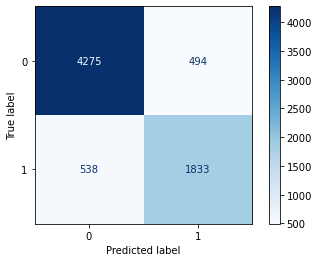

In [57]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model, x_test, y_test, cmap = "Blues")
plt.show()

### Feature Importance

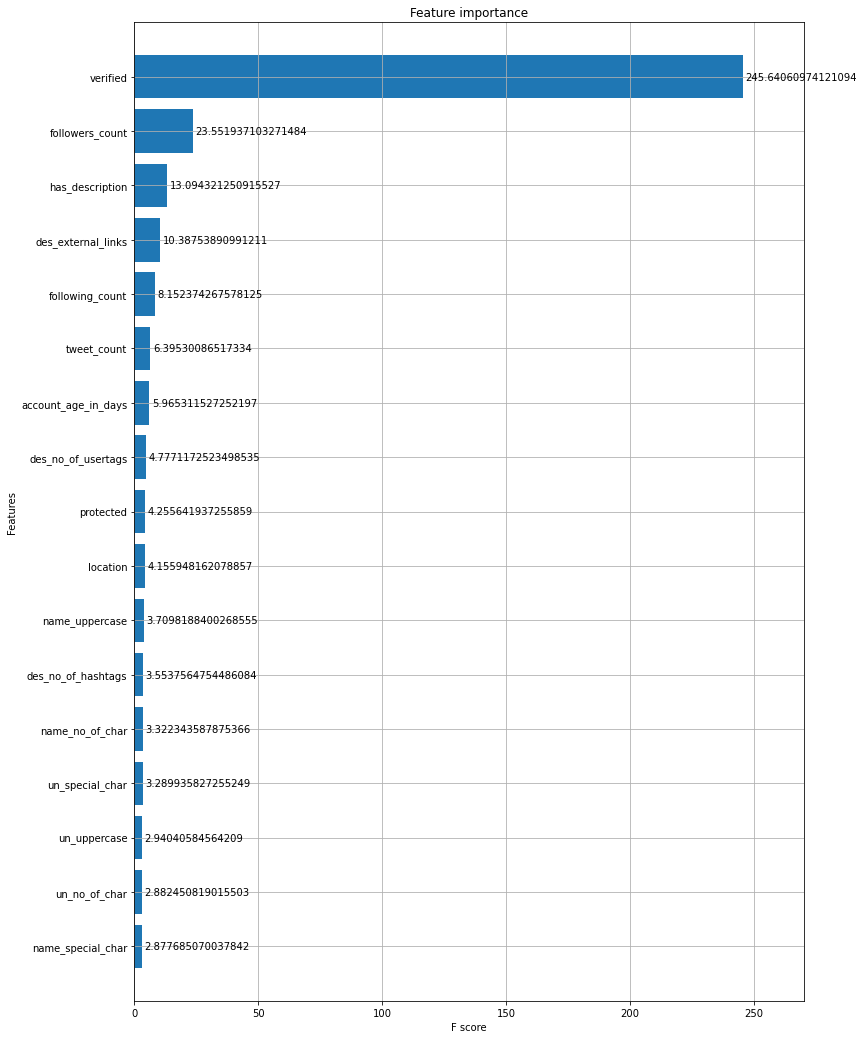

In [58]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model.named_steps["xgbclassifier"], importance_type = 'gain', height=0.8, ax=ax)
plt.show()

In [59]:
# Local Level
shap.initjs()
explainer = shap.TreeExplainer(xgb_model.named_steps["xgbclassifier"], x_train, model_output="probability")
shap_values = explainer.shap_values(x_test)
shap.force_plot(explainer.expected_value, shap_values[1,:], feature_names = x_test.columns)

 99%|===================| 7071/7140 [00:40<00:00]        

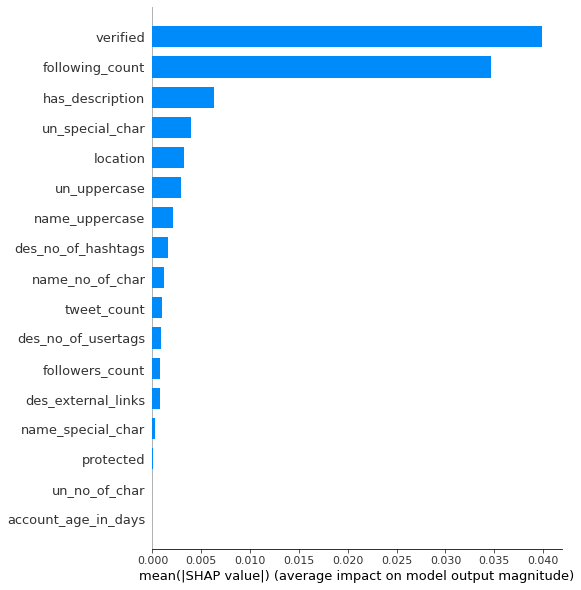

In [60]:
# Global Level
shap.summary_plot(shap_values, feature_names = x_test.columns, plot_type = "bar", sort = True)

### Final Model Selected (XGBoost)

In [158]:
weight_final = dataset['isFraud'].value_counts()[0] / dataset['isFraud'].value_counts()[1]

params_xgb = optim_model.max['params']
xgb_classifier = xgb.XGBClassifier(max_depth = int(params_xgb['max_depth']), 
                                   eta = params_xgb['eta'], 
                                   gamma = params_xgb['gamma'],
                                   subsample = params_xgb['subsample'],
                                   colsample_bytree = params_xgb['colsample_bytree'],
                                   alpha = params_xgb['alpha'],
                                   scale_pos_weight = weight_final,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")

transformer = ExperimentalTransformer()
xgb_final_model_pipeline = make_pipeline(transformer, xgb_classifier)

xgb_final_model = xgb_final_model_pipeline.fit(x, y)

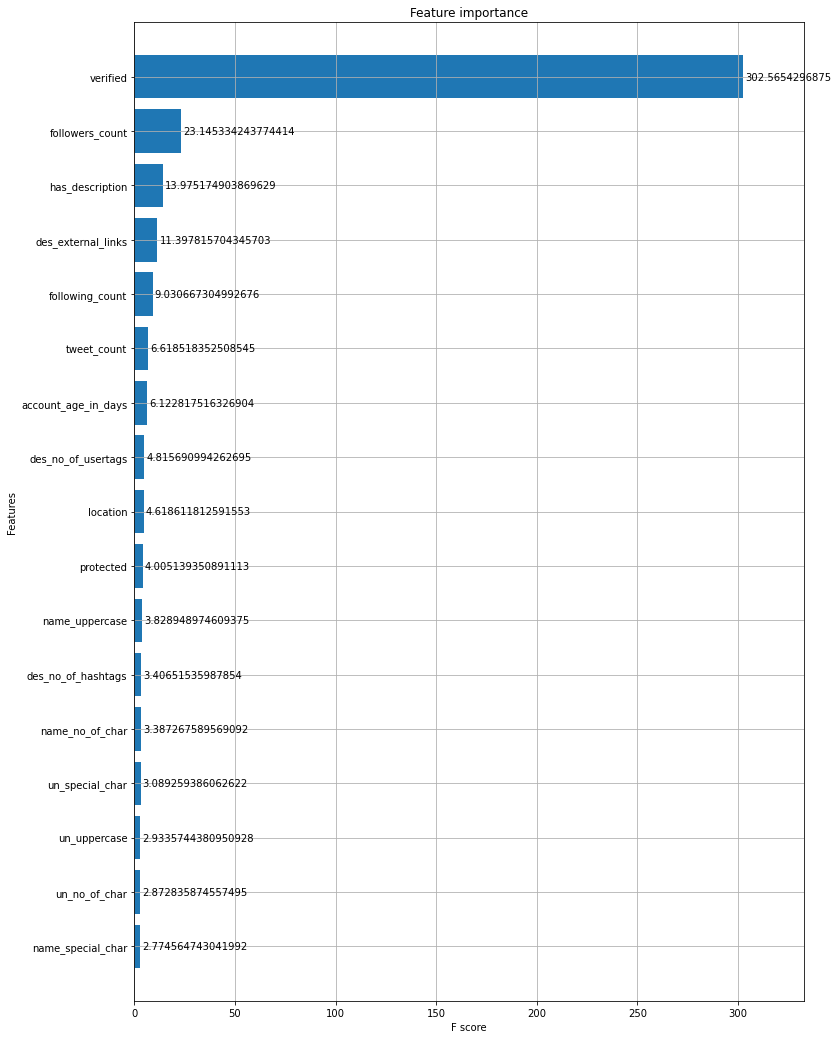

In [159]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_final_model.named_steps["xgbclassifier"], importance_type = 'gain', height=0.8, ax=ax)
plt.show()

In [169]:
# Local Level
shap.initjs()
explainer_final = shap.TreeExplainer(xgb_final_model.named_steps["xgbclassifier"], x, model_output="probability")
shap_values = explainer_final.shap_values(x)
shap.force_plot(explainer_final.expected_value, shap_values[30000,:], feature_names = x.columns)

100%|===================| 35673/35698 [03:25<00:00]        

## 04 Support Vector Machine
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

### Model: Random Search

In [61]:
# Model
svm_classifier = SVC()
transformer = ExperimentalTransformer()
svm_model = make_pipeline(transformer, svm_classifier)

space = dict()

# Kernel type to be used in the algorithm
space["svc__kernel"] = ['poly', 'rbf', 'sigmoid']

# Degree of the polynomial kernel function
space["svc__degree"] = [1, 3, 8]

# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
space["svc__gamma"] = ['scale', 'auto']

# Regularisation parameter
space["svc__C"] = [0.1, 1, 10, 100]

# Enable verbose output
space["svc__verbose"] = [True, False]

# Define search
random_search = RandomizedSearchCV(svm_model, 
                                   space, 
                                   cv = 5, 
                                   scoring = 'f1',
                                   verbose = 2, 
                                   random_state = 123, 
                                   n_jobs = -1)

In [62]:
%%time

# Execute search
results_random_svm = random_search.fit(x_train, np.ravel(y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 2min 31s
Wall time: 16min 16s


In [63]:
# Save the model to disk
# filename = '04 SVM (Random).sav'
# pickle.dump(results_random, open(filename, 'wb'))

# Load the model from disk
# results_random = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_random_svm.best_score_)
print('Best Hyperparameters: %s' % results_random_svm.best_params_)

Best Score: 0.617494160652734
Best Hyperparameters: {'svc__verbose': False, 'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__degree': 1, 'svc__C': 100}


In [64]:
# y_prediction for the best model using RandomSearchCV
y_pred_random = results_random_svm.predict(x_test)

In [65]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_random)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_random)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random)
print(f'Recall: {recall}')

Accuracy: 0.7766106442577031
Log Loss: 7.715658392440901
ROC AUC: 0.7236613712965403
F1-score: 0.6272493573264781
Precision: 0.7033542976939203
Recall: 0.566005904681569


### Model: Grid Search

In [66]:
# Model
svm_classifier = SVC()
transformer = ExperimentalTransformer()
svm_model = make_pipeline(transformer, svm_classifier)

grid = dict()

# Kernel type to be used in the algorithm
grid["svc__kernel"] = ['poly', 'rbf', 'sigmoid']

# Degree of the polynomial kernel function
grid["svc__degree"] = [1, 3, 8]

# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
grid["svc__gamma"] = ['scale', 'auto']

# Regularisation parameter
grid["svc__C"] = [0.1, 1, 10, 100]

# Enable verbose output
grid["svc__verbose"] = [True, False]

# Define search
search = GridSearchCV(svm_model, 
                      grid, 
                      scoring = 'f1',
                      cv = 5, 
                      n_jobs = -1, 
                      verbose = 2)

In [67]:
%%time

# Execute search
results_grid_svm = search.fit(x_train, np.ravel(y_train))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LibSVM]CPU times: total: 3min 30s
Wall time: 7h 36min 45s


In [68]:
# Save the model to disk
# filename = '04 SVM (Grid).sav'
# pickle.dump(results_grid, open(filename, 'wb'))

# Load the model from disk
# results_grid = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_grid_svm.best_score_)
print('Best Hyperparameters: %s' % results_grid_svm.best_params_)

Best Score: 0.6220115304849015
Best Hyperparameters: {'svc__C': 100, 'svc__degree': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__verbose': True}


In [69]:
# y_prediction for the best model using GridSearchCV
y_pred_grid = results_grid_svm.predict(x_test)

In [70]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')

Accuracy: 0.7785714285714286
Log Loss: 7.647936981297021
ROC AUC: 0.728204277608649
F1-score: 0.6342817487855654
Precision: 0.7023565573770492
Recall: 0.5782370307886967


### Model: Optimal Hyperparameters

In [71]:
print("Grid Search:", results_grid_svm.best_score_) 
print("Randomised Search:", results_random_svm.best_score_) 

Grid Search: 0.6220115304849015
Randomised Search: 0.617494160652734


In [72]:
# Model (initialise the object based on parameters selected by )
# random_state = 123
params_svm = results_grid_svm.best_params_

svm_classifier = SVC(C = params_svm["svc__C"], 
                     degree = params_svm["svc__degree"], 
                     gamma = params_svm["svc__gamma"], 
                     kernel = params_svm["svc__kernel"], 
                     verbose = params_svm["svc__verbose"], 
                     random_state = 123)

transformer = ExperimentalTransformer()
svm_model_pipeline = make_pipeline(transformer, svm_classifier)
svm_model = svm_model_pipeline.fit(x_train, np.ravel(y_train))

# Save the model to disk
# filename = '04 SVM (Optimal).sav'
# pickle.dump(svm_model, open(filename, 'wb'))

# Load the model from disk
# rf_regression = pickle.load(open(filename, 'rb'))

[LibSVM]

In [73]:
# y_prediction for the best model
y_pred_optimal = svm_model.predict(x_test)

In [74]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_optimal)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_optimal)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_optimal)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred_optimal)
print(f'Classification Report: \n {report}')

Accuracy: 0.7785714285714286
Log Loss: 7.647936981297021
ROC AUC: 0.728204277608649
F1-score: 0.6342817487855654
Precision: 0.7023565573770492
Recall: 0.5782370307886967
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      4769
           1       0.70      0.58      0.63      2371

    accuracy                           0.78      7140
   macro avg       0.75      0.73      0.74      7140
weighted avg       0.77      0.78      0.77      7140



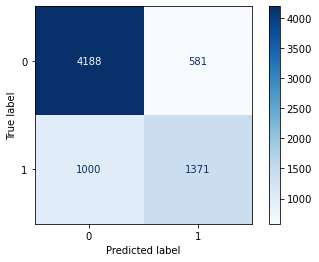

In [75]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(svm_model, x_test, y_test, cmap = "Blues")
plt.show()

### Feature Importance
* Cannot find cause black box model unless use SHAP or perm importance?

In [ ]:
# Feature importance
# x_test_imps = svm_model.named_steps["experimentaltransformer"].transform(x_test)
# imps = permutation_importance(svm_model.named_steps["svc"], x_test, y_test, random_state=123)
# feature = pd.DataFrame(imps.importances_mean, svm_model.named_steps["experimentaltransformer"].columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
# feature

In [ ]:
# feature_chart(feature, "SVM")

## 05 Naive Bayes
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

In [76]:
x_bin_train = x_train[["protected",
               "verified", 
               "location", 
               "un_special_char", 
               "un_uppercase", 
               "name_special_char", 
               "name_uppercase", 
               "des_external_links", 
               "has_description"]]

x_bin_test = x_test[["protected",
               "verified", 
               "location", 
               "un_special_char", 
               "un_uppercase", 
               "name_special_char", 
               "name_uppercase", 
               "des_external_links", 
               "has_description"]]

x_num_train = x_train[["followers_count", 
                 "following_count", 
                 "tweet_count", 
                 "un_no_of_char", 
                 "name_no_of_char", 
                 "des_no_of_usertags", 
                 "des_no_of_hashtags", 
                 "account_age_in_days"]]

x_num_test = x_test[["followers_count", 
                 "following_count", 
                 "tweet_count", 
                 "un_no_of_char", 
                 "name_no_of_char", 
                 "des_no_of_usertags", 
                 "des_no_of_hashtags", 
                 "account_age_in_days"]]

### Model (Random)
* GaussianNB
* BernoulliNB

#### GaussianNB

In [77]:
# Model (GaussianNB)
gnb_classifier = GaussianNB()
transformer = ExperimentalTransformer()
gnb_model = make_pipeline(transformer, gnb_classifier)

space = dict()

# 
space["gaussiannb__var_smoothing"] = np.logspace(0,-9, num=200) 
    
random_search = RandomizedSearchCV(estimator = gnb_model,
                                   param_distributions = space,
                                   scoring = 'f1',
                                   n_jobs = -1,
                                   cv = 5,
                                   verbose = 10,
                                   n_iter = 50,
                                   random_state = 123)

In [78]:
%%time

result_random_gnb = random_search.fit(x_num_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 1.44 s
Wall time: 8.53 s


In [79]:
print('Best Score: %s' % result_random_gnb.best_score_)
print('Best Hyperparameters: %s' % result_random_gnb.best_params_)

Best Score: 0.575643472683347
Best Hyperparameters: {'gaussiannb__var_smoothing': 0.13826221737646557}


In [80]:
y_pred_random_gnb = result_random_gnb.predict(x_num_test)

In [81]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_random_gnb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_random_gnb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random_gnb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random_gnb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random_gnb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random_gnb)
print(f'Recall: {recall}')

Accuracy: 0.5770308123249299
Log Loss: 14.609135524342776
ROC AUC: 0.6446680148813612
F1-score: 0.5705346985210467
Precision: 0.43037974683544306
Recall: 0.8460565162378744


#### BernoulliNB

In [82]:
# Model (BernoulliNB)
bnb_classifier = BernoulliNB()
scaler = StandardScaler()
bnb_model = make_pipeline(scaler, bnb_classifier)

space = dict()

# 
space["bernoullinb__alpha"] = [0, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]
    
random_search = RandomizedSearchCV(estimator = bnb_model,
                                   param_distributions = space,
                                   scoring = 'f1',
                                   n_jobs = -1,
                                   cv = 5,
                                   verbose = 10,
                                   n_iter = 50,
                                   random_state = 123)

In [83]:
%%time

result_random_bnb = random_search.fit(x_bin_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
CPU times: total: 375 ms
Wall time: 630 ms


In [84]:
print('Best Score: %s' % result_random_bnb.best_score_)
print('Best Hyperparameters: %s' % result_random_bnb.best_params_)

Best Score: 0.5541944501420567
Best Hyperparameters: {'bernoullinb__alpha': 0}


In [85]:
y_pred_random_bnb = result_random_bnb.predict(x_bin_test)

In [86]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_random_bnb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_random_bnb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random_bnb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random_bnb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random_bnb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random_bnb)
print(f'Recall: {recall}')

Accuracy: 0.7322128851540616
Log Loss: 9.249120808683251
ROC AUC: 0.6739900483749479
F1-score: 0.5538964069062062
Precision: 0.6198433420365536
Recall: 0.5006326444538169


### Model (Grid)
* GaussianNB
* BernoulliNB

#### GaussianNB

In [87]:
# Model (GaussianNB)
gnb_classifier = GaussianNB()
transformer = ExperimentalTransformer()
gnb_model = make_pipeline(transformer, gnb_classifier)

grid = dict()

# 
grid["gaussiannb__var_smoothing"] = np.logspace(0,-9, num=200) 
    
grid_search = GridSearchCV(estimator = gnb_model,
                           param_grid = grid,
                           scoring = 'f1',
                           n_jobs = -1,
                           cv = 5,
                           verbose = True)

In [88]:
%%time

result_grid_gnb = grid_search.fit(x_num_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: total: 5.5 s
Wall time: 10.9 s


In [89]:
print('Best Score: %s' % result_grid_gnb.best_score_)
print('Best Hyperparameters: %s' % result_grid_gnb.best_params_)

Best Score: 0.5765320776174446
Best Hyperparameters: {'gaussiannb__var_smoothing': 0.17027691722259}


In [90]:
y_pred_grid_gnb = result_grid_gnb.predict(x_num_test)

In [91]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_grid_gnb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_grid_gnb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid_gnb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid_gnb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid_gnb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid_gnb)
print(f'Recall: {recall}')

Accuracy: 0.5903361344537815
Log Loss: 14.149570972021746
ROC AUC: 0.6504927038720741
F1-score: 0.5735529960635661
Precision: 0.43827985739750447
Recall: 0.8296077604386335


#### BernoulliNB

In [92]:
# Model (BernoulliNB)
bnb_classifier = BernoulliNB()
scaler = StandardScaler()
bnb_model = make_pipeline(scaler, bnb_classifier)

grid = dict()

# 
grid["bernoullinb__alpha"] = [0, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]
    
grid_search = GridSearchCV(estimator = bnb_model,
                           param_grid = grid,
                           scoring = 'f1',
                           n_jobs = -1,
                           cv = 5,
                           verbose = True)

In [93]:
%%time

result_grid_bnb = grid_search.fit(x_bin_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
CPU times: total: 328 ms
Wall time: 635 ms


In [94]:
print('Best Score: %s' % result_grid_bnb.best_score_)
print('Best Hyperparameters: %s' % result_grid_bnb.best_params_)

Best Score: 0.5541944501420567
Best Hyperparameters: {'bernoullinb__alpha': 0}


In [95]:
y_pred_grid_bnb = result_grid_bnb.predict(x_bin_test)

In [96]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_grid_bnb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_grid_bnb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid_bnb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid_bnb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid_bnb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid_bnb)
print(f'Recall: {recall}')

Accuracy: 0.7322128851540616
Log Loss: 9.249120808683251
ROC AUC: 0.6739900483749479
F1-score: 0.5538964069062062
Precision: 0.6198433420365536
Recall: 0.5006326444538169


### Model (Optimal Hyperparameters)
* GaussianNB
* BernoulliNB

#### GaussianNB

In [97]:
print("Grid Search (GNB):", result_grid_gnb.best_score_) 
print("Randomised Search (GNB):", result_random_gnb.best_score_) 

Grid Search (GNB): 0.5765320776174446
Randomised Search (GNB): 0.575643472683347


In [98]:
# Model
params_gnb = result_grid_gnb.best_params_

gnb_classifier = GaussianNB(var_smoothing = params_gnb["gaussiannb__var_smoothing"])
transformer = ExperimentalTransformer()
gnb_model_pipeline = make_pipeline(transformer, gnb_classifier)
gnb_model = gnb_model_pipeline.fit(x_num_train, np.ravel(y_train))

# Save the model to disk
# filename = '04 SVM (Optimal).sav'
# pickle.dump(svm_model, open(filename, 'wb'))

# Load the model from disk
# rf_regression = pickle.load(open(filename, 'rb'))

In [99]:
# y_prediction for the best model
y_pred_optimal_gnb = gnb_model.predict(x_num_test)

In [100]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_optimal_gnb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_optimal_gnb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_optimal_gnb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_optimal_gnb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal_gnb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal_gnb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred_optimal_gnb)
print(f'Classification Report: \n {report}')

Accuracy: 0.5903361344537815
Log Loss: 14.149570972021746
ROC AUC: 0.6504927038720741
F1-score: 0.5735529960635661
Precision: 0.43827985739750447
Recall: 0.8296077604386335
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.47      0.61      4769
           1       0.44      0.83      0.57      2371

    accuracy                           0.59      7140
   macro avg       0.64      0.65      0.59      7140
weighted avg       0.71      0.59      0.60      7140



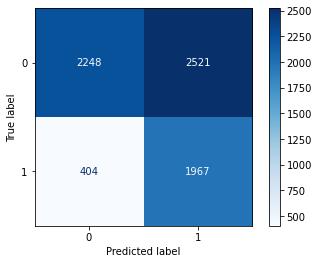

In [102]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(gnb_model, x_num_test, y_test, cmap = "Blues")
plt.show()

#### BernoulliNB

In [103]:
print("Grid Search (BNB):", result_grid_bnb.best_score_) 
print("Randomised Search (BNB):", result_random_bnb.best_score_) 

Grid Search (BNB): 0.5541944501420567
Randomised Search (BNB): 0.5541944501420567


In [104]:
# Model 
params_bnb = result_grid_bnb.best_params_

bnb_classifier = BernoulliNB(alpha = params_bnb["bernoullinb__alpha"])
scaler = StandardScaler()
bnb_model_pipeline = make_pipeline(scaler, bnb_classifier)
bnb_model = bnb_model_pipeline.fit(x_bin_train, np.ravel(y_train))

# Save the model to disk
# filename = '04 SVM (Optimal).sav'
# pickle.dump(svm_model, open(filename, 'wb'))

# Load the model from disk
# rf_regression = pickle.load(open(filename, 'rb'))

In [105]:
# y_prediction for the best model
y_pred_optimal_bnb = bnb_model.predict(x_bin_test)

In [106]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_optimal_bnb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_optimal_bnb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_optimal_bnb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_optimal_bnb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal_bnb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal_bnb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred_optimal_bnb)
print(f'Classification Report: \n {report}')

Accuracy: 0.7322128851540616
Log Loss: 9.249120808683251
ROC AUC: 0.6739900483749479
F1-score: 0.5538964069062062
Precision: 0.6198433420365536
Recall: 0.5006326444538169
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      4769
           1       0.62      0.50      0.55      2371

    accuracy                           0.73      7140
   macro avg       0.70      0.67      0.68      7140
weighted avg       0.72      0.73      0.72      7140



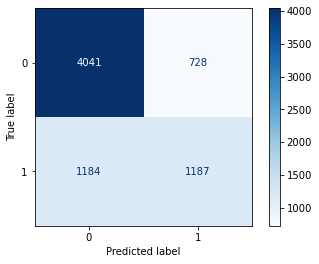

In [107]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(bnb_model, x_bin_test, y_test, cmap = "Blues")
plt.show()

### Feature Importance

#### GaussianNB

In [108]:
# Feature importance
# x_test_imps = gnb_model.named_steps["experimentaltransformer"].transform(x_num_test)
imps = permutation_importance(gnb_model.named_steps["gaussiannb"], x_num_test, y_test, random_state=123)
feature = pd.DataFrame(imps.importances_mean, gnb_model.named_steps["experimentaltransformer"].columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

,Feature Importance
followers_count,0.108852
un_no_of_char,0.000000
name_no_of_char,0.000000
des_no_of_usertags,0.000000
des_no_of_hashtags,0.000000
account_age_in_days,-0.002493
following_count,-0.006779
tweet_count,-0.069860


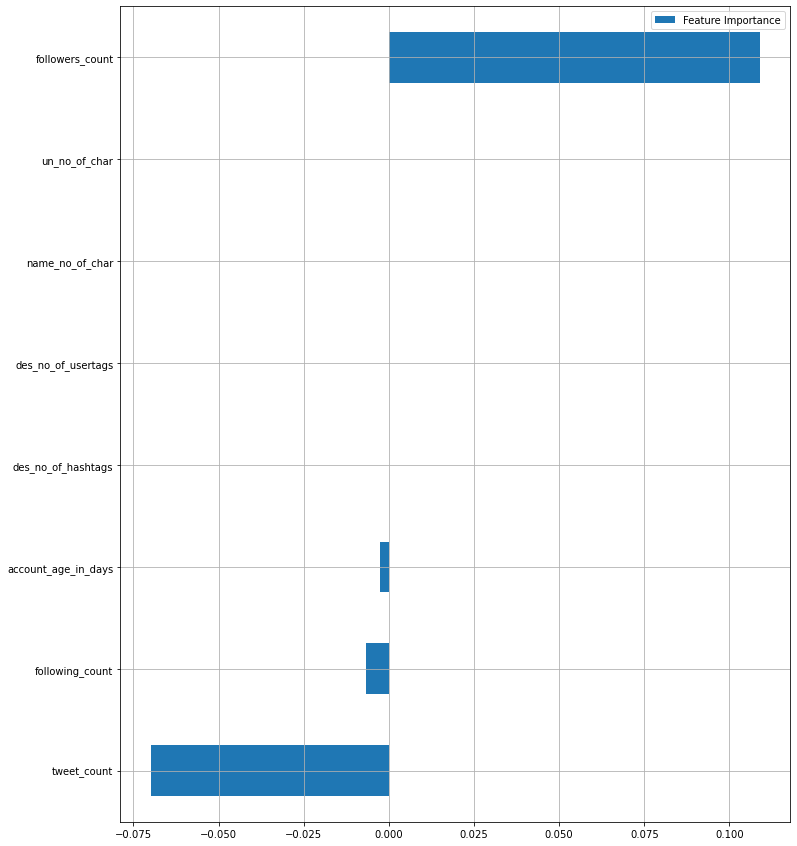

In [109]:
# Feature importance
feature_chart(feature, "GaussianNB")

#### BernoulliNB

In [110]:
# Feature importance
# x_test_imps = bnb_model.named_steps["experimentaltransformer"].transform(x_bin_test)
imps = permutation_importance(bnb_model.named_steps["bernoullinb"], x_bin_test, y_test, random_state=123)
feature = pd.DataFrame(imps.importances_mean, x_bin_test.columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

,Feature Importance
has_description,0.059944
verified,0.032185
des_external_links,0.028739
location,0.026723
protected,0.001317
name_uppercase,0.001176
name_special_char,0.000560
un_special_char,0.000000
un_uppercase,-0.000056


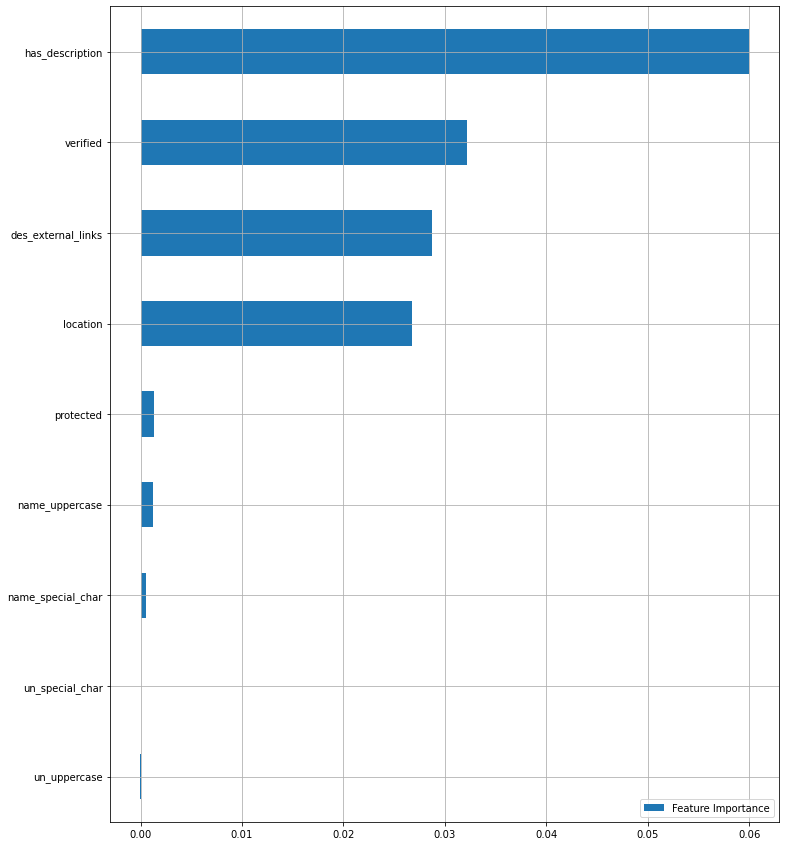

In [111]:
# Feature importance
feature_chart(feature, "BernoulliNB")

## 06 Ensemble Model
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

In [112]:
# Insert after getting optimal hyperparameters!!!!!
params_rf = results_grid_rf.best_params_
params_xgb = optim_model.max['params']
params_svm = results_grid_svm.best_params_

rf_classifier = RandomForestClassifier(bootstrap = params_rf["randomforestclassifier__bootstrap"], 
                                       max_depth = params_rf["randomforestclassifier__max_depth"], 
                                       max_features = params_rf["randomforestclassifier__max_features"], 
                                       min_samples_split = params_rf["randomforestclassifier__min_samples_split"], 
                                       n_estimators = params_rf["randomforestclassifier__n_estimators"])

xgb_classifier = xgb.XGBClassifier(max_depth = int(params_xgb['max_depth']), 
                                   eta = params_xgb['eta'], 
                                   gamma = params_xgb['gamma'],
                                   subsample = params_xgb['subsample'],
                                   colsample_bytree = params_xgb['colsample_bytree'],
                                   alpha = params_xgb['alpha'],
                                   scale_pos_weight = weight_train,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")

svm_classifier = SVC(C = params_svm["svc__C"], 
                     degree = params_svm["svc__degree"], 
                     gamma = params_svm["svc__gamma"], 
                     kernel = params_svm["svc__kernel"], 
                     verbose = params_svm["svc__verbose"], 
                     random_state = 123)

log_regression = LogisticRegression()

transformer = ExperimentalTransformer()
rf_model_pipeline = make_pipeline(transformer, rf_classifier)
xgb_model_pipeline = make_pipeline(transformer, xgb_classifier)
svm_model_pipeline = make_pipeline(transformer, svm_classifier)

In [113]:
# clf = [rf_model_pipeline, xgb_model_pipeline, svm_model_pipeline]
clf = [rf_model_pipeline, xgb_model_pipeline]

for algo in clf:
    score = cross_val_score(algo, x_test, y_test, cv = 7, scoring = 'f1')
    print("The f1 score of {} is:".format(algo),score.mean())

# clf = [('rfc', rf_model_pipeline), ('xgb', xgb_model_pipeline), ('svm', svm_model_pipeline)] #list of (str, estimator)
clf = [('rfc', rf_model_pipeline), ('xgb', xgb_model_pipeline)] #list of (str, estimator)

stack_model_pipeline = StackingClassifier(estimators = clf, final_estimator = log_regression)
score = cross_val_score(stack_model_pipeline, x_test, y_test, cv = 7, scoring = 'f1')
print(score)
print("The f1 score of is:", score.mean())

The f1 score of Pipeline(steps=[('experimentaltransformer', ExperimentalTransformer()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=40,
                                        max_features='sqrt',
                                        min_samples_split=10,
                                        n_estimators=800))]) is: 0.7581747934490405
The f1 score of Pipeline(steps=[('experimentaltransformer', ExperimentalTransformer()),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.5944848180232206, base_score=None,
                               booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9230403033643909,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               eta=0.01349512788400522, eval_metric='log

In [114]:
%%time

stack_model = stack_model_pipeline.fit(x_train, y_train)

CPU times: total: 8min 3s
Wall time: 6min 21s


In [115]:
y_pred_stack = stack_model.predict(x_test)

In [116]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test, y_pred_stack)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test, y_pred_stack)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_stack)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_stack)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_stack)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_stack)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test, y_pred_stack)
print(f'Classification Report: \n {report}')

Accuracy: 0.8607843137254902
Log Loss: 4.808379326782405
ROC AUC: 0.8281332261577234
F1-score: 0.7771300448430494
Precision: 0.829583532790809
Recall: 0.7309152256431886
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4769
           1       0.83      0.73      0.78      2371

    accuracy                           0.86      7140
   macro avg       0.85      0.83      0.84      7140
weighted avg       0.86      0.86      0.86      7140



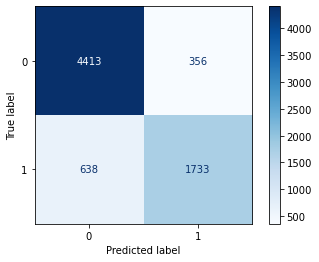

In [117]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(stack_model, x_test, y_test, cmap = "Blues")
plt.show()

### Feature Importance

In [ ]:
x_test_imps = stack_model.transform(x_test)

rf_class = stack_model.estimators_[0].named_steps["randomforestclassifier"]
xgb_class = stack_model.estimators_[1].named_steps["xgbclassifier"]
# svm_class = stack_model.estimators_[2].named_steps["svc"]

rf_imps = permutation_importance(rf_class, x_test_imps, y_test, random_state=123)
xgb_imps = permutation_importance(xgb_class, x_test_imps, y_test, random_state=123)
# svm_imps = permutation_importance(svm_class, x_test_imps, y_test, random_state=123)

In [ ]:
# rf_xgb_imps = np.add(rf_imps.importances_mean, xgb_imps.importances_mean)
# rf_xgb_svm_imps = np.add(rf_xgb_imps, svm_imps.importances_mean)

In [ ]:
# Feature importance
# feature = pd.DataFrame(rf_xgb_imps, x_test_imps.columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
# feature

In [ ]:
# Feature importance
# feature_chart(feature, "Ensemble")

## Saving Pickle Files

In [118]:
filename = "00 Baseline.sav"
pickle.dump(baseline_model, open(filename, 'wb'))

In [119]:
filename = '01 Log Regression.sav'
pickle.dump(log_model, open(filename, 'wb'))

In [120]:
filename = '02 Random Forest (grid).sav'
pickle.dump(results_grid_rf, open(filename, 'wb'))

filename = '02 Random Forest (random).sav'
pickle.dump(results_random_rf, open(filename, 'wb'))

filename = '02 Random Forest (optimal).sav'
pickle.dump(rf_model, open(filename, 'wb'))

In [121]:
filename = '03 XGBoost (grid).sav'
pickle.dump(results_grid_xgb, open(filename, 'wb'))

filename = '03 XGBoost (random).sav'
pickle.dump(results_random_xgb, open(filename, 'wb'))

filename = '03 XGBoost (optimal).sav'
pickle.dump(xgb_model, open(filename, 'wb'))

filename = 'xgb_shap.sav'
pickle.dump(explainer, open(filename, 'wb'))

In [170]:
filename = '03 XGBoost (final).sav'
pickle.dump(xgb_final_model, open(filename, 'wb'))

filename = 'xgb_final_shap.sav'
pickle.dump(explainer_final, open(filename, 'wb'))

In [122]:
filename = '04 SVM (grid).sav'
pickle.dump(results_grid_svm, open(filename, 'wb'))

filename = '04 SVM (random).sav'
pickle.dump(results_random_svm, open(filename, 'wb'))

filename = '04 SVM (optimal).sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [123]:
filename = '05 Gaussian NB (grid).sav'
pickle.dump(result_grid_gnb, open(filename, 'wb'))

filename = '05 Gaussian NB (random).sav'
pickle.dump(result_random_gnb, open(filename, 'wb'))

filename = '05 Gaussian NB (optimal).sav'
pickle.dump(gnb_model, open(filename, 'wb'))

In [124]:
filename = '05 Bernoulli NB (grid).sav'
pickle.dump(result_grid_bnb, open(filename, 'wb'))

filename = '05 Bernoulli NB (random).sav'
pickle.dump(result_random_bnb, open(filename, 'wb'))

filename = '05 Bernoulli NB (optimal).sav'
pickle.dump(bnb_model, open(filename, 'wb'))

In [125]:
filename = '06 Ensemble.sav'
pickle.dump(stack_model, open(filename, 'wb'))

# Slicing Based Model Evaluation
* Random Forest
* XGBoost

## 01 verification
* Random Forest 
* XGBoost

In [126]:
print("Number of Verified Accounts: " + str(len(dataset[dataset['verified'] == 1].index)))
print("Number of Non-Verified Accounts: " + str(len(dataset[dataset['verified'] == 0].index)))

verified_accounts_dataset = dataset[dataset['verified'] == 1]
non_verified_accounts_dataset = dataset[dataset['verified'] == 0]

# Getting X and y
x_verified = verified_accounts_dataset.drop(columns = ['isFraud'])
y_verified = verified_accounts_dataset['isFraud']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_verified, x_test_verified, y_train_verified, y_test_verified = train_test_split(x_verified, y_verified, test_size = 0.2, random_state=101)
print("Train set (verified):", x_train_verified.shape, y_train_verified.shape)
print("Test set (verified):", x_test_verified.shape, y_test_verified.shape)

# Getting X and y
x_non_verified = non_verified_accounts_dataset.drop(columns = ['isFraud'])
y_non_verified = non_verified_accounts_dataset['isFraud']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_non_verified, x_test_non_verified, y_train_non_verified, y_test_non_verified = train_test_split(x_non_verified, y_non_verified, test_size = 0.2, random_state=101)
print("Train set (non-verified):", x_train_non_verified.shape, y_train_non_verified.shape)
print("Test set (non-verified):", x_test_non_verified.shape, y_test_non_verified.shape)

Number of Verified Accounts: 7284
Number of Non-Verified Accounts: 28414
Train set (verified): (5827, 17) (5827,)
Test set (verified): (1457, 17) (1457,)
Train set (non-verified): (22731, 17) (22731,)
Test set (non-verified): (5683, 17) (5683,)


### verified (1) - Random Forest

In [127]:
#load optimal RF model
params_rf = results_grid_rf.best_params_

rf_classifier = RandomForestClassifier(bootstrap = params_rf["randomforestclassifier__bootstrap"], 
                                       max_depth = params_rf["randomforestclassifier__max_depth"], 
                                       max_features = params_rf["randomforestclassifier__max_features"], 
                                       min_samples_split = params_rf["randomforestclassifier__min_samples_split"], 
                                       n_estimators = params_rf["randomforestclassifier__n_estimators"])

transformer = ExperimentalTransformer()
rf_model_pipeline = make_pipeline(transformer, rf_classifier)

In [128]:
# y_prediction for the best model
rf_model_verified = rf_model_pipeline.fit(x_train_verified, np.ravel(y_train_verified))
y_pred_verified_rf = rf_model_verified.predict(x_test_verified)

In [129]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test_verified, y_pred_verified_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_verified, y_pred_verified_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_verified, y_pred_verified_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_verified, y_pred_verified_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_verified, y_pred_verified_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_verified, y_pred_verified_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_verified, y_pred_verified_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.9615648592999314
Log Loss: 1.3275043767380166
ROC AUC: 0.5912301061007957
F1-score: 0.3
Precision: 0.8
Recall: 0.18461538461538463
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1392
           1       0.80      0.18      0.30        65

    accuracy                           0.96      1457
   macro avg       0.88      0.59      0.64      1457
weighted avg       0.96      0.96      0.95      1457



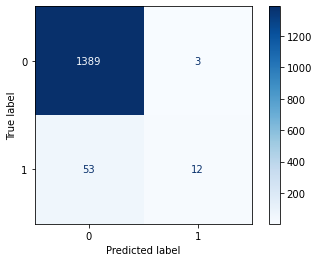

In [130]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_verified, x_test_verified, y_test_verified, cmap = "Blues")
plt.show()

### verified (0) - Random Forest

In [131]:
# y_prediction for the best model
rf_model_non_verified = rf_model_pipeline.fit(x_train_non_verified, np.ravel(y_train_non_verified))
y_pred_non_verified_rf = rf_model_non_verified.predict(x_test_non_verified)

In [132]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_non_verified, y_pred_non_verified_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_non_verified, y_pred_non_verified_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_non_verified, y_pred_non_verified_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.8236846735878938
Log Loss: 6.089767692899821
ROC AUC: 0.8085274939307575
F1-score: 0.7704993128721942
Precision: 0.8196881091617934
Recall: 0.7268798617113224
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      3369
           1       0.82      0.73      0.77      2314

    accuracy                           0.82      5683
   macro avg       0.82      0.81      0.81      5683
weighted avg       0.82      0.82      0.82      5683



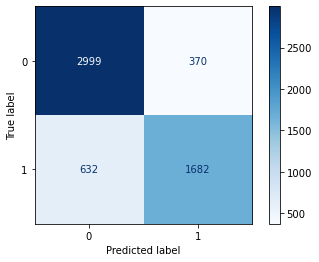

In [133]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_non_verified, x_test_non_verified, y_test_non_verified, cmap = "Blues")
plt.show()

### verified (1) - XGBoost

In [134]:
#load optimal XGBoost model
params_xgb = optim_model.max['params']
xgb_classifier = xgb.XGBClassifier(max_depth = int(params_xgb['max_depth']), 
                                   eta = params_xgb['eta'], 
                                   gamma = params_xgb['gamma'],
                                   subsample = params_xgb['subsample'],
                                   colsample_bytree = params_xgb['colsample_bytree'],
                                   alpha = params_xgb['alpha'],
                                   scale_pos_weight = weight_train,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")

transformer = ExperimentalTransformer()
xgb_model_pipeline = make_pipeline(transformer, xgb_classifier)

In [135]:
# y_prediction for the best model
xgb_model_verified = xgb_model_pipeline.fit(x_train_verified, y_train_verified)
y_pred_verified_xgb = xgb_model_verified.predict(x_test_verified)

In [136]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test_verified, y_pred_verified_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_verified, y_pred_verified_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_verified, y_pred_verified_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_verified, y_pred_verified_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_verified, y_pred_verified_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_verified, y_pred_verified_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_verified, y_pred_verified_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.9608785175017158
Log Loss: 1.3512119778256155
ROC AUC: 0.6128702475685235
F1-score: 0.3448275862068966
Precision: 0.6818181818181818
Recall: 0.23076923076923078
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1392
           1       0.68      0.23      0.34        65

    accuracy                           0.96      1457
   macro avg       0.82      0.61      0.66      1457
weighted avg       0.95      0.96      0.95      1457



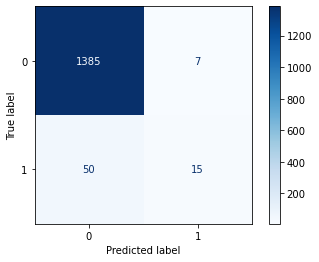

In [137]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_verified, x_test_verified, y_test_verified, cmap = "Blues")
plt.show()

### verified (0) - XGBoost

In [138]:
# y_prediction for the best model
xgb_model_non_verified = xgb_model_pipeline.fit(x_train_non_verified, y_train_non_verified)
y_pred_non_verified_xgb = xgb_model_non_verified.predict(x_test_non_verified)

In [139]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_non_verified, y_pred_non_verified_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.8194615519971846
Log Loss: 6.235649546692753
ROC AUC: 0.8131529582473583
F1-score: 0.778497409326425
Precision: 0.777825711820535
Recall: 0.7791702679343129
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      3369
           1       0.78      0.78      0.78      2314

    accuracy                           0.82      5683
   macro avg       0.81      0.81      0.81      5683
weighted avg       0.82      0.82      0.82      5683



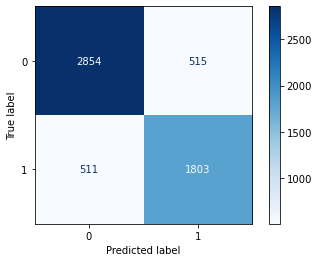

In [140]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_non_verified, x_test_non_verified, y_test_non_verified, cmap = "Blues")
plt.show()

## 02 followers_count
* Random Forest 
* XGBoost

Upper Quartile: 10584
Train set (high): (7140, 17) (7140,)
Test set (high): (1785, 17) (1785,)
Train set (low): (21418, 17) (21418,)
Test set (low): (5355, 17) (5355,)


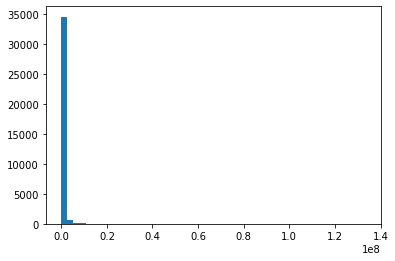

In [141]:
plot = plt.hist(dataset['followers_count'], bins=50)
print("Upper Quartile: " + str(int(dataset['followers_count'].describe()['75%'])))

high_followers_dataset = dataset[dataset['followers_count'] > 10584]
low_followers_dataset = dataset[dataset['followers_count'] <= 10584]

# Getting X and y
x_high = high_followers_dataset.drop(columns = ['isFraud'])
y_high = high_followers_dataset['isFraud']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_high, x_test_high, y_train_high, y_test_high = train_test_split(x_high, y_high, test_size = 0.2, random_state=101)
print("Train set (high):", x_train_high.shape, y_train_high.shape)
print("Test set (high):", x_test_high.shape, y_test_high.shape)

# Getting X and y
x_low = low_followers_dataset.drop(columns = ['isFraud'])
y_low = low_followers_dataset['isFraud']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train_low, x_test_low, y_train_low, y_test_low = train_test_split(x_low, y_low, test_size = 0.2, random_state=101)
print("Train set (low):", x_train_low.shape, y_train_low.shape)
print("Test set (low):", x_test_low.shape, y_test_low.shape)

### followers_count > 75% - Random Forest

In [142]:
#load optimal RF model
params_rf = results_grid_rf.best_params_

rf_classifier = RandomForestClassifier(bootstrap = params_rf["randomforestclassifier__bootstrap"], 
                                       max_depth = params_rf["randomforestclassifier__max_depth"], 
                                       max_features = params_rf["randomforestclassifier__max_features"], 
                                       min_samples_split = params_rf["randomforestclassifier__min_samples_split"], 
                                       n_estimators = params_rf["randomforestclassifier__n_estimators"])

transformer = ExperimentalTransformer()
rf_model_pipeline = make_pipeline(transformer, rf_classifier)

In [143]:
# y_prediction for the best model
rf_model_high = rf_model_pipeline.fit(x_train_high, np.ravel(y_train_high))
y_pred_high_rf = rf_model_high.predict(x_test_high)

In [144]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test_high, y_pred_high_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_high, y_pred_high_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_high, y_pred_high_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_high, y_pred_high_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_high, y_pred_high_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_high, y_pred_high_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_high, y_pred_high_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.9142857142857143
Log Loss: 2.9604746113025655
ROC AUC: 0.6427877824858756
F1-score: 0.42696629213483145
Precision: 0.76
Recall: 0.296875
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      1593
           1       0.76      0.30      0.43       192

    accuracy                           0.91      1785
   macro avg       0.84      0.64      0.69      1785
weighted avg       0.90      0.91      0.90      1785



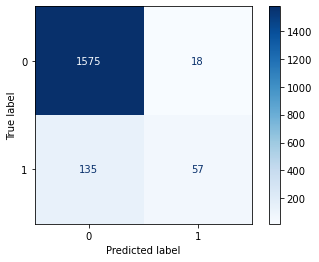

In [145]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_high, x_test_high, y_test_high, cmap = "Blues")
plt.show()

### followers_count <= 75% - Random Forest

In [146]:
# y_prediction for the best model
rf_model_low = rf_model_pipeline.fit(x_train_low, np.ravel(y_train_low))
y_pred_low_rf = rf_model_low.predict(x_test_low)

In [147]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test_low, y_pred_low_rf)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_low, y_pred_low_rf)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_low, y_pred_low_rf)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_low, y_pred_low_rf)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_low, y_pred_low_rf)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_low, y_pred_low_rf)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_low, y_pred_low_rf)
print(f'Classification Report: \n {report}')

Accuracy: 0.8366013071895425
Log Loss: 5.643638695933615
ROC AUC: 0.823437785168941
F1-score: 0.7906197654941375
Precision: 0.8377281947261663
Recall: 0.7485274127775261
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      3148
           1       0.84      0.75      0.79      2207

    accuracy                           0.84      5355
   macro avg       0.84      0.82      0.83      5355
weighted avg       0.84      0.84      0.83      5355



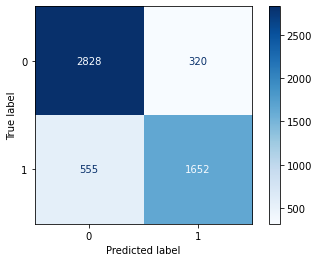

In [148]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(rf_model_low, x_test_low, y_test_low, cmap = "Blues")
plt.show()

### followers_count > 75% - XGBoost

In [149]:
#load optimal XGBoost model
params_xgb = optim_model.max['params']
xgb_classifier = xgb.XGBClassifier(max_depth = int(params_xgb['max_depth']), 
                                   eta = params_xgb['eta'], 
                                   gamma = params_xgb['gamma'],
                                   subsample = params_xgb['subsample'],
                                   colsample_bytree = params_xgb['colsample_bytree'],
                                   alpha = params_xgb['alpha'],
                                   scale_pos_weight = weight_train,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")

transformer = ExperimentalTransformer()
xgb_model_pipeline = make_pipeline(transformer, xgb_classifier)

In [150]:
# y_prediction for the best model
xgb_model_high = xgb_model_pipeline.fit(x_train_high, np.ravel(y_train_high))
y_pred_high_xgb = xgb_model_high.predict(x_test_high)

In [151]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test_high, y_pred_high_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_high, y_pred_high_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_high, y_pred_high_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_high, y_pred_high_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_high, y_pred_high_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_high, y_pred_high_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_high, y_pred_high_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.9170868347338935
Log Loss: 2.863736297562538
ROC AUC: 0.7016144852479598
F1-score: 0.5256410256410257
Precision: 0.6833333333333333
Recall: 0.4270833333333333
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      1593
           1       0.68      0.43      0.53       192

    accuracy                           0.92      1785
   macro avg       0.81      0.70      0.74      1785
weighted avg       0.91      0.92      0.91      1785



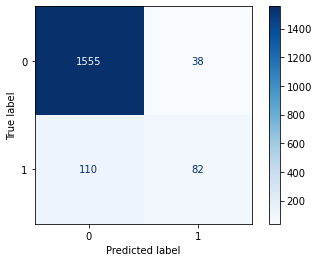

In [152]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_high, x_test_high, y_test_high, cmap = "Blues")
plt.show()

### followers_count <= 75% - XGBoost

In [153]:
# y_prediction for the best model
xgb_model_low = xgb_model_pipeline.fit(x_train_low, np.ravel(y_train_low))
y_pred_low_xgb = xgb_model_low.predict(x_test_low)

In [154]:
# Error Metrics
accuracy = metrics.accuracy_score(y_test_low, y_pred_low_xgb)
print(f'Accuracy: {accuracy}')
lg_loss = metrics.log_loss(y_test_low, y_pred_low_xgb)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test_low, y_pred_low_xgb)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test_low, y_pred_low_xgb)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test_low, y_pred_low_xgb)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test_low, y_pred_low_xgb)
print(f'Recall: {recall}')
report = metrics.classification_report(y_test_low, y_pred_low_xgb)
print(f'Classification Report: \n {report}')

Accuracy: 0.8287581699346406
Log Loss: 5.9145519643232465
ROC AUC: 0.8234035289125682
F1-score: 0.7923930269413629
Precision: 0.7918552036199095
Recall: 0.792931581332125
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      3148
           1       0.79      0.79      0.79      2207

    accuracy                           0.83      5355
   macro avg       0.82      0.82      0.82      5355
weighted avg       0.83      0.83      0.83      5355



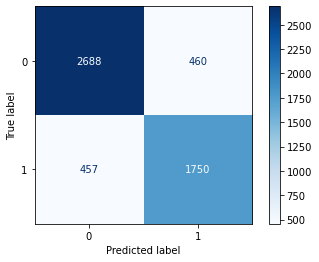

In [155]:
# Confusion Matrix Plot
metrics.plot_confusion_matrix(xgb_model_low, x_test_low, y_test_low, cmap = "Blues")
plt.show()

## Saving Pickle Files

In [156]:
filename = "SB 01 Random Forest (verified)"
pickle.dump(rf_model_verified, open(filename, 'wb'))

filename = "SB 01 Random Forest (non-verified)"
pickle.dump(rf_model_non_verified, open(filename, 'wb'))

filename = "SB 02 XGBoost (verified)"
pickle.dump(xgb_model_verified, open(filename, 'wb'))

filename = "SB 02 XGBoost (non-verified)"
pickle.dump(xgb_model_non_verified, open(filename, 'wb'))

In [157]:
filename = "SB 01 Random Forest (followers - high)"
pickle.dump(rf_model_high, open(filename, 'wb'))

filename = "SB 01 Random Forest (followers - low)"
pickle.dump(rf_model_low, open(filename, 'wb'))

filename = "SB 02 XGBoost (followers - high)"
pickle.dump(xgb_model_high, open(filename, 'wb'))

filename = "SB 02 XGBoost (followers - low)"
pickle.dump(xgb_model_low, open(filename, 'wb'))